참고 코드
https://wikidocs.net/103802

## Import

In [ ]:
import pandas as pd
import random
import os
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier


In [ ]:
class CFG:
    SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 固定

## Data Load

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

In [ ]:
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

# EDA

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)


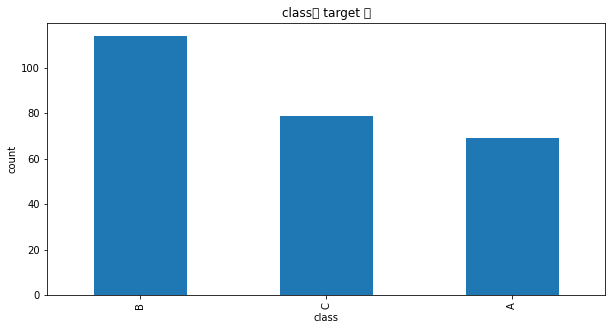

In [ ]:
plt.figure(figsize=(10,5)) 
train_y.value_counts().plot(kind='bar')
plt.xlabel('class')
plt.ylabel('count')
plt.title('class별 target 수')
plt.show() 

## Data Pre-processing
### Label-Encoding

In [ ]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

In [ ]:
snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

In [ ]:
train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [ ]:

for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])


# Transformer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 最初のサブレイヤー：マルチヘッドアテンション
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 2番目のサブレイヤー：ポジションワイズフィードフォワードニューラルネットワーク
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
vocab_size = 128  
max_len = 19 


훈련용 리뷰 개수 : 262
테스트용 리뷰 개수 : 175


In [ ]:
def transformer():
  embedding_dim = 32  # Embedding Vector の次元
  num_heads = 2  # アテンションヘッドの数
  dff = 32  # ポジションワイズニューラルネットワークの隠れ層サイズ

  inputs = tf.keras.layers.Input(shape=(max_len,))
  embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
  x = embedding_layer(inputs)
  
  x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 2, padding='valid', activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  
  transformer_block = TransformerBlock(64, num_heads, dff)
  x = transformer_block(x)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  outputs = tf.keras.layers.Dense(3, activation="softmax")(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  adam = keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer = adam, loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model = KerasClassifier(build_fn=transformer, epochs=90, batch_size=32, verbose=0)
model._estimator_type="classifier"

<ipython-input-17-a7c06bf71cf7>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=transformer, epochs=90, batch_size=32, verbose=0)


In [ ]:
model.fit(train_x, train_y, batch_size=32, epochs=2000)

In [ ]:
params = {
    'batch_size':[16, 32],
    'epochs':[60, 80, 90, 120, 150],
}

In [ ]:
predictions = model.predict(test_x)
predictions

6/6 [==============================] - 0s 7ms/step


array([0, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 1, 1, 2, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0,
       1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1])

In [ ]:
cross_val_score(model , train_x, train_y, cv=5) 

array([0.9245283 , 0.88679248, 0.94230771, 0.96153843, 0.96153843])

## Inference

In [ ]:
preds = predictions
print('Done.')

Done.


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['class'] = class_le.inverse_transform(preds)

In [ ]:
submit

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [ ]:
submit.to_csv('./answer/submit.csv', index=False)